### Michelle Ide, GitHub mishide
### DataKind project "Broadband Access" Sept 18 2021
#### This notebook imports the Florida data and conducts analysis on the gaps or contradictions using the socio-economic variables in the ACS data to understand why these exist.

In [1]:
# import libraries need for notebook

import pandas as pd
import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt
from scipy.stats import t, sem
import seaborn as sns

In [2]:
# import Florida data

ookla = pd.read_csv('../data/ookla_combined_fl.csv')
fcc = pd.read_csv('../data/fcc_477_census_tract_FL.csv')
acs = pd.read_csv('../data/acs_2019_FL.csv')

#### Look at the data

In [3]:
print(ookla.head())

           quadkey  avg_d_kbps  avg_u_kbps  avg_lat_ms  tests  devices   type  \
0  320201332021332       90726       28194          35      3        2  fixed   
1  320231100220123      159542       31827          14     60       10  fixed   
2  320231102200112      211000       52752          14     37       18  fixed   
3  320231223033003      115365       20575          15      7        5  fixed   
4  320212301232330      217592       48549           9     21        8  fixed   

  quarter  year  STATEFP  COUNTYFP  TRACTCE              AFFGEOID  \
0      Q1  2021       12        37   970302  1400000US12037970302   
1      Q1  2021       12        99      905  1400000US12099000905   
2      Q1  2021       12        99     5916  1400000US12099005916   
3      Q1  2021       12        87   971200  1400000US12087971200   
4      Q1  2021       12        57    11906  1400000US12057011906   

         GEOID     NAME LSAD      ALAND    AWATER  \
0  12037970302  9703.02   CT  126051207  5861

In [4]:
print(fcc.head())

         tract      max_dn      max_up      dn10     dn100     dn250  \
0  12001000200  979.959184   53.995265  1.925170  1.000000  1.000000   
1  12001000301  990.015000   34.653840  1.560000  1.060000  1.000000   
2  12001000302  989.663158   44.797558  1.178947  1.010526  1.000000   
3  12001000400  947.382979   33.170979  1.329787  0.946809  0.946809   
4  12001000500  967.066914  392.588372  2.130112  1.405204  1.364312   

   fiber_100u  state  
0    0.020408     12  
1    0.000000     12  
2    0.010526     12  
3    0.000000     12  
4    0.371747     12  


In [5]:
print(acs.head())

   state  county  tract        geoid  f_broadband  f_computer   f_ba  f_black  \
0     12       1    200  12001000200        0.816       0.968  0.279    0.184   
1     12       1    301  12001000301        0.723       0.879  0.450    0.429   
2     12       1    302  12001000302        0.818       0.885  0.315    0.223   
3     12       1    400  12001000400        0.786       0.849  0.245    0.560   
4     12       1    500  12001000500        0.852       0.942  0.557    0.199   

   f_hispanic  log_mhi  ...  nhh_computer_no_internet  nhh_no_computer  \
0       0.130     9.79  ...                       392               82   
1       0.069    10.40  ...                       285              211   
2       0.241    10.40  ...                        72              125   
3       0.078    10.59  ...                       152              324   
4       0.094    10.61  ...                       227              146   

   den_age  n_children  n_children_computer  n_children_computer_and

#### Merge the dataframes together on GEOID

In [6]:
fcc = fcc.rename(columns = {'tract':'GEOID'})
acs = acs.rename(columns = {'geoid':'GEOID'})

In [7]:
from functools import reduce
dfs = [fcc, ookla, acs]
df_final = reduce(lambda left,right: pd.merge(left,right,on='GEOID'), dfs)

In [8]:
df_final = df_final.drop_duplicates()

#### Look at the results and clean for specific analysis, remove columns not needed for this analysis

In [9]:
df_final.columns

Index(['GEOID', 'max_dn', 'max_up', 'dn10', 'dn100', 'dn250', 'fiber_100u',
       'state_x', 'quadkey', 'avg_d_kbps', 'avg_u_kbps', 'avg_lat_ms', 'tests',
       'devices', 'type', 'quarter', 'year', 'STATEFP', 'COUNTYFP', 'TRACTCE',
       'AFFGEOID', 'NAME', 'LSAD', 'ALAND', 'AWATER', 'tile', 'state_y',
       'county', 'tract', 'f_broadband', 'f_computer', 'f_ba', 'f_black',
       'f_hispanic', 'log_mhi', 'mhi', 'population', 'households', 'broadband',
       'computer', 'black', 'hispanic', 'mhi.1', 'ba', 'den_computers',
       'n_computer', 'n_broadband', 'den_black', 'n_black', 'den_hispanic',
       'n_hispanic', 'den_ba', 'n_ba', 'nhh_computer', 'nhh_broadband',
       'nhh_computer_any_internet', 'nhh_computer_and_dialup',
       'nhh_computer_and_broadband', 'nhh_computer_no_internet',
       'nhh_no_computer', 'den_age', 'n_children', 'n_children_computer',
       'n_children_computer_and_dialup', 'n_children_computer_and_broadband',
       'n_children_computer_no_interne

#### Drop initial unwanted columns

In [10]:
geo_df = df_final[['GEOID','f_black','f_hispanic','f_ba']]
tract_df = df_final[['TRACTCE','f_black','f_hispanic','f_ba']]

In [11]:
geo_df = geo_df.drop_duplicates()

In [12]:
geo_df.head()

,GEOID,f_black,f_hispanic,f_ba
0,12001000200,0.184,0.130,0.279
33,12001000301,0.429,0.069,0.450
66,12001000302,0.223,0.241,0.315
95,12001000400,0.560,0.078,0.245
141,12001000500,0.199,0.094,0.557


#### Note: there were negatives in the f_black column that were removed below

In [13]:
geo_df = geo_df.loc[(geo_df.f_black>0)]
geo_df = geo_df.loc[(geo_df.f_hispanic>0)]

#### This gives us hispanic and black desities by geoid (location), the remaining percentage are simiply non-hispanic/black.  Plotting these comparisons show back and hispanic population is highly dense in specific locations.  Next step would be to compare these densities to access and speed.

In [14]:
geo_df['remaining'] = 1-(geo_df.f_black + geo_df.f_hispanic)
geo_df

,GEOID,f_black,f_hispanic,f_ba,remaining
0,12001000200,0.184,0.130,0.279,0.686
33,12001000301,0.429,0.069,0.450,0.502
66,12001000302,0.223,0.241,0.315,0.536
95,12001000400,0.560,0.078,0.245,0.362
141,12001000500,0.199,0.094,0.557,0.707
...,...,...,...,...,...
259010,12133970103,0.106,0.094,0.150,0.800
259039,12133970104,0.334,0.004,0.176,0.662
259105,12133970200,0.077,0.019,0.088,0.904
259222,12133970302,0.250,0.049,0.086,0.701


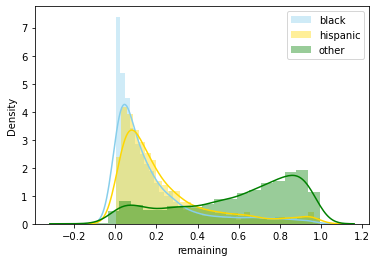

In [15]:
# Use 'seaborn' to plot by race as available in the data

# stop deprecated warnings
import warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)


sns.distplot( geo_df.f_black, color='skyblue', label='black')
sns.distplot( geo_df.f_hispanic, color='gold', label='hispanic')
sns.distplot( geo_df.remaining, color = 'green', label='other')
plt.legend()
plt.show()